In [1]:
from pathlib import Path
from itertools import zip_longest
from typing import List, Optional, Dict, Union, Tuple
from dataclasses import dataclass
import itertools
import os

import numpy as np
import matplotlib.pyplot as plt
import polars as pl
from scipy.io import loadmat


from UnifiedMomentumModel import Momentum


# Use Latex Fonts
plt.rcParams.update({"text.usetex": True, "font.family": "serif"})

lesdir = Path(os.getcwd()) / "LES_data"
figdir = Path(os.getcwd()).parent / "fig"
figdir.mkdir(exist_ok=True, parents=True)
figdir_eps = figdir / "eps"
figdir_eps.mkdir(exist_ok=True, parents=True)

# Collect data to compare
Data to compared is collected in a dictionary of lists of `MomentumSolution` objects (`Dict[str, List[MomentumSolution]]`)

## Load LES Data
We first load the LES data into a `MomentumSolution`-like object. First we define this object:

In [2]:
@dataclass
class LESSolution:
    """
    Stores the results from LES solutions for later comparison with Unified
    Momentum solution.
    """

    Ctprime: float
    an: float
    u4: float
    v4: float
    x0: float
    dp: float
    Cp: float
    Ct: float
    dp_NL: Optional[float] = 0.0
    niter: Optional[int] = 1
    converged: Optional[bool] = True
    beta: Optional[float] = 0.0


MomentumSolutionLike = Union[Momentum.MomentumSolution, LESSolution]

In [3]:
# Set up results dictionary
results: Dict[str, List[MomentumSolutionLike]] = {}

In [4]:
def load_LES_data_ctp(filename: Path) -> List[LESSolution]:
    data = loadmat(filename)

    out = []
    for Cp, Ct, Ctp, p4, a, u4, x0 in zip_longest(
        data["Cp_ctp_input"][0],
        data["Ct_ctp_input"][0],
        data["Ctp_vector"][0],
        data["P4_ctp_input"][0],
        data["a_ctp_input"][0],
        data["u4_ctp_input"][0],
        data["x0_ctp_input"][0],
        fillvalue=np.nan,
    ):
        out.append(LESSolution(Ctp, a, u4, 0, x0, p4, Cp, Ct))

    return out


def load_LES_data_ct(filename: Path) -> List[LESSolution]:
    data = loadmat(filename)
    out = []

    for Cp, Ct, p4, a, u4, x0 in zip_longest(
        data["Cp_ct_input"][0],
        data["Ct_ct_input"][0],
        data["P4_ct_input"][0],
        data["a_ct_input"][0],
        data["u4_ct_input"][0],
        data["x0_ct_input_positive_Ct_only"][0],
        fillvalue=np.nan,
    ):
        Ctp = Ct / (1 - a) ** 2

        # Remove LES points with infeasable induction values
        if a < 1.1:
            out.append(LESSolution(Ctp, a, u4, 0, x0, p4, Cp, Ct))
    return out


def load_LES_data_NREL(filename: Path) -> List[LESSolution]:
    df = pl.read_csv(
        filename, has_header=False, columns=[0, 1], new_columns=["a", "Ct"]
    )
    out = []

    for a, ct in df.iter_rows():
        out.append(LESSolution(np.nan, a, np.nan, np.nan, np.nan, np.nan, np.nan, ct))
    return out


# Load LES
LES_data_fn = lesdir / "LES_streamtube_data.mat"
NREL_LES_data_fn = lesdir / "ct_data_les_tony.txt"

results["LES_ctp"] = load_LES_data_ctp(LES_data_fn)
results["LES_ct"] = load_LES_data_ct(LES_data_fn)
results["LES_NREL"] = load_LES_data_NREL(NREL_LES_data_fn)

# Add a priori pressure, pap

In [5]:
results["LES a priori"] = []
for sol in results["LES_ct"]:
    results["LES a priori"].append(
        LESSolution(
            sol.Ctprime,
            sol.an,
            np.nan,
            np.nan,
            np.nan,
            -(
                0.5 * sol.Ctprime * (1 - sol.an) ** 2 * np.cos(0) ** 2
                + 0.5 * sol.u4**2
                - 0.5
            ),
            np.nan,
            np.nan,
        )
    )

# Generate Model Data

In [6]:
models_to_compare = {
    "classical": Momentum.Heck(),
    "linear": Momentum.UnifiedMomentum(cached=False, max_iter=0),
    "nonlinear": Momentum.UnifiedMomentum(),
    "nonlinear_minus": Momentum.UnifiedMomentum(beta=0.9 * 0.1403),
    "nonlinear_plus": Momentum.UnifiedMomentum(beta=1.1 * 0.1403),
}
Ctprimes = np.concatenate(
    [np.linspace(-1, 12, 100), np.linspace(12, 4000, 400), [100000]]
)


# Run unified model and variations
for name, model in models_to_compare.items():
    results[name] = []
    for Ctprime in Ctprimes:
        results[name].append(model(Ctprime, 0))

/home/jaime/Repositories/Unified-Momentum-Model/UnifiedMomentumModel/Momentum.py:99: RuntimeWarning: invalid value encountered in sqrt
  e_a = 1 - np.sqrt(1 - u4**2 - v4**2) / (np.sqrt(Ctprime) * np.cos(yaw)) - a
/home/jaime/Repositories/Unified-Momentum-Model/UnifiedMomentumModel/Utilities/FixedPointIteration.py:57: RuntimeWarning: All-NaN axis encountered
  max_resid = [np.nanmax(np.abs(_r)) for _r in residuals]


# Add steiros

In [7]:
ass = np.linspace(0, 1)

out = []
for a in ass:
    Ct = 4 * a * (3 - a) / (3 * (1 + a))
    u4 = (1 - a) / (1 + a)
    p4 = -8 / 3 * (a / (a + 1)) ** 2
    Ctprime = Ct / (1 - a) ** 2
    Cp = Ctprime * (1 - a) ** 3
    out.append(LESSolution(Ctprime, a, u4, 0, np.nan, p4, Cp, Ct))

results["steiros"] = out

/tmp/ipykernel_30244/2406742001.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  Ctprime = Ct / (1 - a) ** 2
/tmp/ipykernel_30244/2406742001.py:9: RuntimeWarning: invalid value encountered in scalar multiply
  Cp = Ctprime * (1 - a) ** 3


# Add unified momentum model while fixing $p_4$ to LES pressure

In [8]:
class UnifiedMomentumFixedP(Momentum.UnifiedMomentum):
    """
    A modified unified momentum model with fixed outlet pressure, p4.
    """

    def initial_guess(self, Ctprime, yaw, p4):
        values = super().initial_guess(Ctprime, yaw)
        values[4, 0] = p4
        return values

    def residual(self, x, Ctprime, yaw, p4):
        r = super().residual(x, Ctprime, yaw)
        residuals = (r[0], r[1], r[2], r[3], np.array([0.0]))
        return residuals

    def post_process(self, result, Ctprime, yaw, p4):
        return super().post_process(result, Ctprime, yaw)


out = []
model = UnifiedMomentumFixedP()
for res in results["LES_ct"]:
    Ctprime, p4 = res.Ctprime, res.dp
    sol = model(Ctprime, 0, p4)
    sol.dp[0] = np.nan
    out.append(sol)

results["fixed_p"] = out

# Plotting

## Figure helper function

In [9]:
def setup_plot_like_mike(
    results: Dict[str, MomentumSolutionLike],
    ch1: str,
    ch2: str,
    ylabels: Tuple[str, str],
    keys: Optional[List[str]] = None,
    range_keys: Optional[Tuple[str, str]] = None,
    plot_kwargs: Dict[str, dict] = {},
    legend=True,
) -> List[List[plt.Axes]]:
    """
    Sets up a subfigure with 4 axes, and plots two channels (ch1, ch2) against
    C_T' and a_n. Returns the four axes.
    """
    if keys is None:
        keys = list(results)

    flip = -1 if ch2 == "dp" else 1

    fig, axes = plt.subplots(2, 2, sharex="col", sharey="row", figsize=(5, 4), dpi=150)
    plt.subplots_adjust(wspace=0.15, hspace=0.15)

    # Plot uncertainty range if provided
    if range_keys is not None:
        key1, key2 = range_keys
        sol_list1 = results[key1]
        sol_list2 = results[key2]
        ch1_val1 = [getattr(sol, ch1)[0] for sol in sol_list1]
        ch1_val2 = [getattr(sol, ch1)[0] for sol in sol_list2]
        ch2_val1 = [flip * getattr(sol, ch2)[0] for sol in sol_list1]
        ch2_val2 = [flip * getattr(sol, ch2)[0] for sol in sol_list2]

        Ctprime = [sol.Ctprime for sol in sol_list1]
        an = [sol.an[0] for sol in sol_list1]

        axes[0, 0].fill_between(an, ch1_val1, ch1_val2, color="0.5", alpha=0.5)
        axes[1, 0].fill_between(an, ch2_val1, ch2_val2, color="0.5", alpha=0.5)

        axes[0, 1].fill_between(Ctprime, ch1_val1, ch1_val2, color="0.5", alpha=0.5)
        axes[1, 1].fill_between(Ctprime, ch2_val1, ch2_val2, color="0.5", alpha=0.5)

    # Plot lines
    for name in keys:
        sol_list = results[name]

        _plot_kwargs = plot_kwargs[name] if name in plot_kwargs else {}

        ch1_val = [getattr(sol, ch1) for sol in sol_list]
        ch2_val = [flip * getattr(sol, ch2) for sol in sol_list]

        Ctprime = [sol.Ctprime for sol in sol_list]
        an = [sol.an for sol in sol_list]

        axes[0, 0].plot(an, ch1_val, **_plot_kwargs)
        axes[1, 0].plot(an, ch2_val, **_plot_kwargs)

        # if name != "LES_ct":
        axes[0, 1].plot(Ctprime, ch1_val, **_plot_kwargs)
        axes[1, 1].plot(Ctprime, ch2_val, **_plot_kwargs)

    # Axis labels
    axes[0, 0].set_ylabel(ylabels[0])
    axes[1, 0].set_ylabel(ylabels[1])

    axes[1, 0].set_xlabel("$a_n$")
    axes[1, 1].set_xlabel("$C_T'$")

    for ax, text in zip(axes.ravel(), ["a)", "b)", "c)", "d)"]):
        ax.text(-0.1, 1.0, text, ha="left", va="top", transform=ax.transAxes)

    # Grid passing through origin
    [ax.axhline(0, lw=1, c="0.7", ls="-", zorder=-100) for ax in axes.ravel()]
    [ax.axvline(0, lw=1, c="0.7", ls="-", zorder=-100) for ax in axes.ravel()]

    # Legend if needed
    if legend:
        axes[0, 0].legend(
            ncol=2, loc="lower center", bbox_to_anchor=(1.05, 1.1), fontsize="small"
        )

    return axes

In [10]:
plot_kwargs = {
    "LES_ctp": dict(ls="", marker=".", ms=8, c="0.5", label="LES (MIT) $C_T'$ input"),
    "LES_ct": dict(ls="", marker=".", ms=8, c="b", label="LES (MIT) $C_T$ input"),
    "LES_NREL": dict(
        ls="", marker="d", ms=2, c="tab:pink", label="LES (NREL) $C_T$ input"
    ),
    "classical": dict(c="r", label="Classical Model"),
    "linear": dict(label="Unified model (linear)"),
    "nonlinear": dict(c="k", lw=2, label="Unified model"),
    "fixed_p": dict(
        ls="", marker="x", ms=2, c="tab:green", label="Unified model (LES pressure)"
    ),
    "nonlinear_variation": dict(label="nonlinear (variation)"),
    "LES a priori": dict(
        ls="", marker="s", ms=2, c="tab:orange", label=r"LES (a priori)"
    ),
    "steiros": dict(ls="--", c="tab:pink", label="Steiros \& Hultmark"),
}

# Figure 2 - $C_p$ and $C_T$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


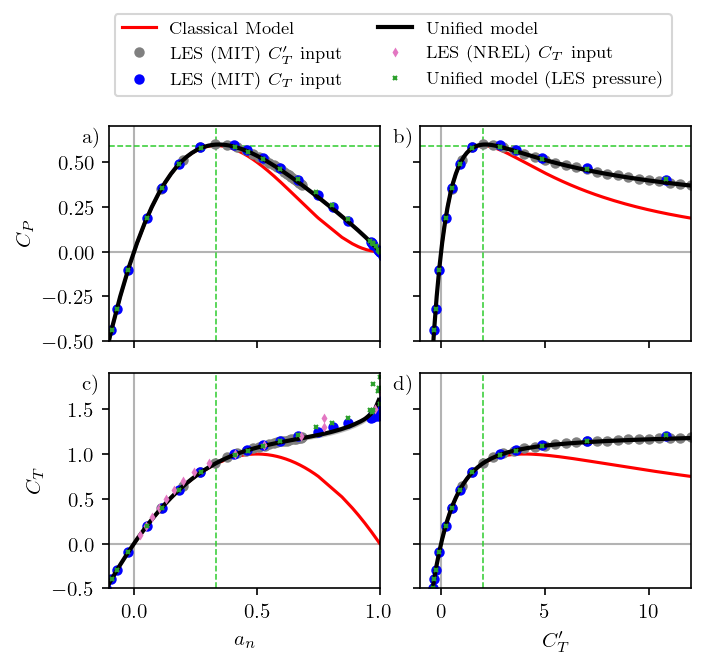

In [11]:
plot_order = [
    "classical",
    # "linear",
    "LES_ctp",
    "LES_ct",
    "nonlinear",
    # "LES a priori",
    "LES_NREL",
    "fixed_p",
    # "steiros",
]

axes = setup_plot_like_mike(
    results,
    "Cp",
    "Ct",
    ("$C_P$", "$C_T$"),
    keys=plot_order,
    range_keys=("nonlinear_minus", "nonlinear_plus"),
    plot_kwargs=plot_kwargs,
)


# Plot Classical betz limit as green dashed lines
betz_line_kwargs = dict(lw=0.75, ls="--", c="limegreen", zorder=-100)
axes[0, 0].axvline(1 / 3, **betz_line_kwargs)
axes[1, 0].axvline(1 / 3, **betz_line_kwargs)

axes[0, 1].axvline(2, **betz_line_kwargs)
axes[1, 1].axvline(2, **betz_line_kwargs)

# Horizontal lines
axes[0, 0].axhline(16 / 27, **betz_line_kwargs)
axes[0, 1].axhline(16 / 27, **betz_line_kwargs)

# axis limits
axes[0, 0].set_xlim(-0.1, 1)
axes[1, 1].set_xlim(-1, 12)
axes[0, 0].set_ylim(-0.5, 0.7)
axes[1, 1].set_ylim(-0.5, 1.9)
plt.savefig(figdir / "Figure2_Cp_Ct.png", dpi=500, bbox_inches="tight")
plt.savefig(figdir_eps / "Figure2_Cp_Ct.eps", bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


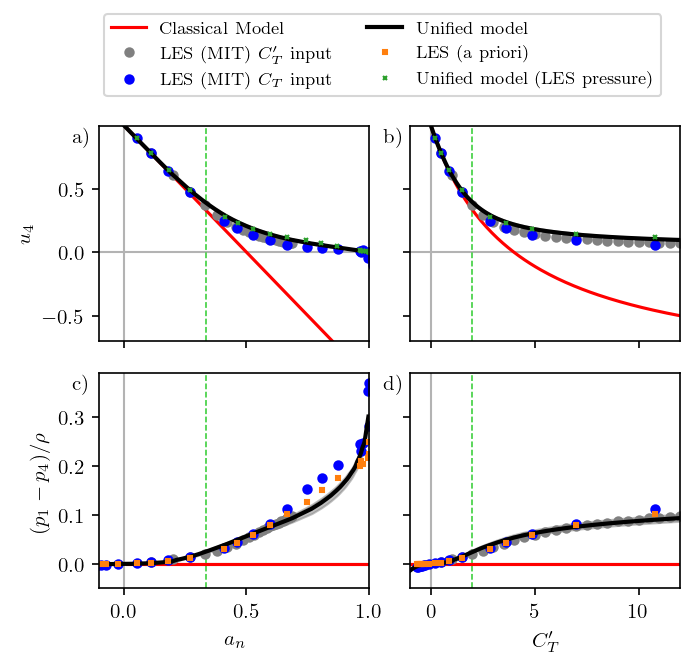

In [12]:
plot_order = [
    "classical",
    # "linear",
    "LES_ctp",
    "LES_ct",
    "nonlinear",
    "LES a priori",
    # "LES_NREL",
    "fixed_p",
    # "steiros",
]


axes = setup_plot_like_mike(
    results,
    "u4",
    "dp",
    ("$u_4$", r"$(p_1-p_4)/\rho$"),
    keys=plot_order,
    range_keys=("nonlinear_minus", "nonlinear_plus"),
    plot_kwargs=plot_kwargs,
)


# Plot Classical betz limit as green dashed lines
betz_line_kwargs = dict(lw=0.75, ls="--", c="limegreen", zorder=-100)
axes[0, 0].axvline(1 / 3, **betz_line_kwargs)
axes[1, 0].axvline(1 / 3, **betz_line_kwargs)

axes[0, 1].axvline(2, **betz_line_kwargs)
axes[1, 1].axvline(2, **betz_line_kwargs)


# axis limits
axes[0, 0].set_xlim(-0.1, 1)
axes[1, 1].set_xlim(-1, 12)
axes[0, 0].set_ylim(-0.7, 0.99)
axes[1, 1].set_ylim(-0.05, 0.39)
plt.savefig(figdir / "Figure3_u4_p4.png", dpi=500, bbox_inches="tight")
plt.savefig(figdir_eps / "Figure3_u4_p4.eps", bbox_inches="tight")